In [1]:
#We load in the specific data needed
import polars as pl
import numpy as np
import os
from pathlib import Path
import pandas as pd
from datetime import date
import datetime
import hvplot.polars
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.interpolate import bisplrep, bisplev
from datetime import timedelta
from patsy import dmatrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
import joblib
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
from sklearn.model_selection import ParameterGrid  # 
from keras.optimizers import RMSprop
import statsmodels.api as sm

In [12]:
# data_nor = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/Modeling/data_set_train_tech_nonscaled.parquet')
# datat_nor = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/Modeling/data_set_test_tech_nonscaled.parquet')

data = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/Modeling/data_set_train_val_tech_standardized_filter.parquet')
datat = pd.read_parquet('/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Data/Modeling/data_set_test_tech_scaled_all_sso_filter.parquet')

# prc_filter = 0.125

impl_volatility = 'impl_volatility_h_1_step'
# data_nor = data_nor[data_nor['prc_option'] >= prc_filter]
# datat_nor = datat_nor[datat_nor['prc_option'] >= prc_filter]

test_data = datat[datat['date'] >= '2021-01-01']
total_train = data[data['date'] < '2021-01-01']

# # data_sso = data_sso[data_sso['prc_option'] > prc_filter]
# # datat_sso = datat_sso[datat_sso['prc_option'] > prc_filter]

basic = ['moneyness', 'T', 'moneyness_squared', 'tau_squared', 'moneyness_tau']
option_specific = ['spread_option', 'volume', 'prc_option', 'previous_iv', 'previous_iv_all']
macro_features = ['1Y_bond','2Y_bond','FF_rate', 'gold_price','reces_indi','10Y_RIR', 'CLOSE_vix', 'hi-lo_vix']
stock_specific = ['BID', 'ASK', 'daily_return_indicator_stock', '5_day_rolling_return_stock', 'hi-lo_stock', ]

tickers = ['ticker_AAPL', 'ticker_AMZN', 'ticker_META', 'ticker_MSFT','ticker_NVDA', 'ticker_TSLA'  ]

totalList = basic + macro_features + option_specific + stock_specific + tickers 

totalList = ['T',
 'moneyness',
 'previous_iv',
 'spread_option',
 '2Y_bond',
 'RET',
 'cp_flag',
 'ticker_TSLA',
 'ticker_AMZN']

# totalList = ['moneyness', 'T'] + macro_features + option_specific + stock_specific + tickers


totalList_standardize = totalList + ['impl_volatility', 'date', 'ticker']


tickers_groups = ['AMZN', 'TSLA', ['META', 'MSFT','NVDA', 'AAPL']]
# data_train = data_trains[data_trains['date'] < '2020-01-01']
# data_validate = data_trains[data_trains['date'] >= '2020-01-01']

In [3]:
data

,date,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,...,ticker_MSFT,ticker_NVDA,ticker_TSLA,Ticker,impl_volatility_h_1_step,impl_volatility_h_5_step,dollar_volume,total_iv_weighted,previous_iv,previous_iv_all
421,2019-01-02,1,0.224218,-0.470324,-0.468200,-0.329434,-0.384042,0.559793,0.012080,-0.478085,...,0,0,0,AMZN,1.445527,0.643147,-0.238959,-0.175597,-0.056179,-0.283184
422,2019-01-02,1,0.195566,-0.461663,-0.463541,-0.327707,-0.372108,0.507672,0.033609,-0.462784,...,0,0,0,AMZN,1.204495,0.546600,-0.238859,-0.175542,-0.056179,-0.283184
423,2019-01-02,1,0.197954,-0.457766,-0.463964,-0.326269,-0.335037,0.523699,0.036926,-0.461884,...,0,0,0,AMZN,1.224912,0.552881,-0.238776,-0.175491,-0.056179,-0.283184
424,2019-01-02,1,0.200342,-0.469458,-0.463541,-0.329290,-0.373378,0.503224,0.022960,-0.468995,...,0,0,0,AMZN,1.245268,0.559628,-0.238943,-0.175590,-0.056179,-0.283184
425,2019-01-02,1,0.035593,1.431971,1.484853,0.127964,0.013337,0.436638,2.174139,-0.237812,...,0,0,0,AMZN,0.530190,0.399060,2.214955,1.025472,-0.056179,-0.283184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173367,2020-12-31,0,1.792907,3.902399,3.905520,-0.315334,-0.358905,0.258224,-2.053130,-0.378718,...,0,0,0,AMZN,0.356984,0.265274,-0.050959,-0.121191,-0.860331,-0.524777
173368,2020-12-31,0,1.788132,3.746509,3.748802,-0.329434,-0.376171,0.258676,-2.016479,-0.375973,...,0,0,0,AMZN,0.355609,0.265490,-0.222204,-0.170750,-0.860331,-0.524777
173369,2020-12-31,0,1.783356,3.573298,3.577258,-0.325837,-0.358651,0.256440,-1.984904,-0.372507,...,0,0,0,AMZN,0.355770,0.265789,-0.182627,-0.159416,-0.860331,-0.524777
173370,2020-12-31,0,1.778581,3.423903,3.422658,-0.326700,-0.306090,0.256743,-1.946709,-0.369897,...,0,0,0,AMZN,0.353283,0.266182,-0.194042,-0.162682,-0.860331,-0.524777


In [4]:
mean_values = data.drop(columns=['date', 'Ticker']).mean()
std_values = data.drop(columns=['date', 'Ticker']).std()
print("Mean values:")
print(mean_values)
print("\nStandard Deviation values:")
print(std_values)
print("\n" + "-"*50 + "\n")

Mean values:
cp_flag                         4.504166e-01
strike_price                   -4.338415e-17
best_bid                       -1.608418e-16
best_offer                     -4.219272e-17
volume                          0.000000e+00
open_interest                  -4.930016e-19
impl_volatility                 5.971458e-01
delta                           1.602255e-17
gamma                          -4.486315e-17
vega                           -6.573355e-18
theta                          -1.248938e-16
prc_option                      7.222474e-17
trading_days_till_exp           3.023743e-17
PRC                            -9.761433e-17
PRC_actual                     -3.575905e-16
Year                            1.987060e-13
Annual_Dividend_Yield           4.979317e-17
T                              -3.602199e-16
2Y_bond                        -2.313821e-16
Forward_Price                  -9.367031e-17
moneyness                       1.104077e-15
trading_day                     9.465632e-

Retraining final model on combined 2019 and 2020 data...
Epoch 1/50
5405/5405 ━━━━━━━━━━━━━━━━━━━━ 2s 258us/step - loss: 0.0860 - mse: 0.0860
Epoch 2/50
5405/5405 ━━━━━━━━━━━━━━━━━━━━ 1s 266us/step - loss: 0.0352 - mse: 0.0352
Epoch 3/50
5405/5405 ━━━━━━━━━━━━━━━━━━━━ 2s 278us/step - loss: 0.0327 - mse: 0.0327
Epoch 4/50
5405/5405 ━━━━━━━━━━━━━━━━━━━━ 1s 258us/step - loss: 0.0317 - mse: 0.0317
Epoch 5/50
5405/5405 ━━━━━━━━━━━━━━━━━━━━ 1s 266us/step - loss: 0.0309 - mse: 0.0309
Epoch 6/50
5405/5405 ━━━━━━━━━━━━━━━━━━━━ 2s 284us/step - loss: 0.0307 - mse: 0.0307
Epoch 7/50
5405/5405 ━━━━━━━━━━━━━━━━━━━━ 1s 269us/step - loss: 0.0307 - mse: 0.0307
Epoch 8/50
5405/5405 ━━━━━━━━━━━━━━━━━━━━ 2s 305us/step - loss: 0.0303 - mse: 0.0303
Epoch 9/50
5405/5405 ━━━━━━━━━━━━━━━━━━━━ 1s 274us/step - loss: 0.0304 - mse: 0.0304
Epoch 10/50
5405/5405 ━━━━━━━━━━━━━━━━━━━━ 2s 287us/step - loss: 0.0303 - mse: 0.0303
Epoch 11/50
5405/5405 ━━━━━━━━━━━━━━━━━━━━ 2s 291us/step - loss: 0.0304 - mse: 0.0304
Epoch 

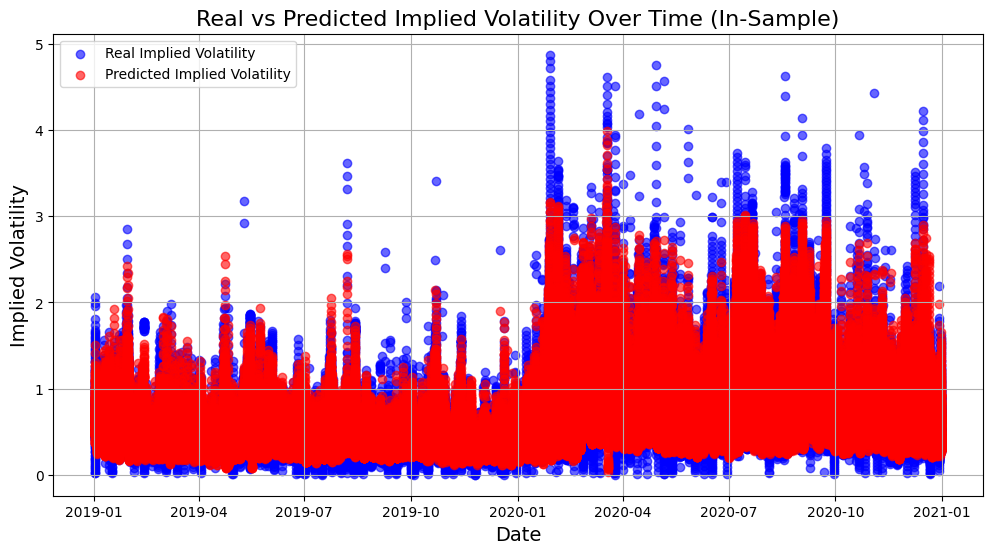

In-sample RMSE: 0.1605
In-sample R²: 0.8591


In [6]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
import joblib
import tensorflow as tf
import random
import matplotlib.pyplot as plt

# Set seed for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# Define your neural network model creation function
def create_model(input_dim, neurons=32, layers=1, dropout_rate=0.0):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(input_dim,)))
    
    for layer in range(layers):
        # Halve the neuron count with each layer, starting from the initial `neurons` value
        neurons_in_layer = max(1, neurons // (2 ** layer))
        model.add(tf.keras.layers.Dense(neurons_in_layer, activation='relu'))
        model.add(tf.keras.layers.Dropout(dropout_rate))
    
    model.add(tf.keras.layers.Dense(1, activation='linear'))
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
                  loss='mean_squared_error',
                  metrics=['mse'])
    return model

def train_and_evaluate(IV, data, selected_features, epochs=100, batch_size=32, neurons=64, layers=2, dropout_rate=0.2, verbose=0):
    if verbose >= 1:
        print("Retraining final model on combined 2019 and 2020 data...")

    # Combine training and validation data (2019 and 2020)
    combined_data = data[data['date'].dt.year <= 2020]
    combined_x = combined_data[selected_features]
    combined_y = combined_data[IV]

    input_dim = combined_x.shape[1]

    final_model = create_model(input_dim, neurons=neurons, layers=layers, dropout_rate=dropout_rate)
    final_model.fit(
        combined_x,
        combined_y,
        epochs=epochs,
        batch_size=batch_size,
        verbose=1
    )

    # In-sample predictions and score calculation
    y_pred_in_sample = final_model.predict(combined_x)
    in_sample_rmse = np.sqrt(mean_squared_error(combined_y, y_pred_in_sample))
    in_sample_r2 = r2_score(combined_y, y_pred_in_sample)

    plot_real_vs_predicted(combined_data, combined_y, y_pred_in_sample, 'In-Sample')

    if verbose >= 1:
        print(f"In-sample RMSE: {in_sample_rmse:.4f}")
        print(f"In-sample R²: {in_sample_r2:.4f}")

    return final_model

def plot_real_vs_predicted(test_data, real_values, predicted_values, title):
    """
    Plot Real vs Predicted Implied Volatility over time.

    Parameters:
    test_data (pd.DataFrame): The test dataset containing the date information.
    real_values (np.array or pd.Series): The real implied volatility values.
    predicted_values (np.array or pd.Series): The predicted implied volatility values.
    title (str): The title for the plot.
    """
    plt.figure(figsize=(12, 6))
    
    # Scatter plot for Real Implied Volatility
    plt.scatter(test_data['date'], real_values, label='Real Implied Volatility', color='blue', alpha=0.6)
    
    # Scatter plot for Predicted Implied Volatility
    plt.scatter(test_data['date'], predicted_values, label='Predicted Implied Volatility', color='red', alpha=0.6)
    
    # Labels and title
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Implied Volatility', fontsize=14)
    plt.title(f'Real vs Predicted Implied Volatility Over Time ({title})', fontsize=16)
    
    # Add a legend
    plt.legend()
    
    # Grid for better visualization
    plt.grid(True)
    
    # Display the plot
    plt.show()

# Define your hyperparameters for the model
epochs = 50
batch_size = 32
neurons = 32
layers = 1
dropout_rate = 0.05

# Run the function with your call or put options data
final_model_nn = train_and_evaluate(impl_volatility, data, totalList, epochs, batch_size, neurons, layers, dropout_rate, verbose=1)


<>:17: SyntaxWarning: invalid escape sequence '\('
<>:17: SyntaxWarning: invalid escape sequence '\('
/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_4058/2907560046.py:17: SyntaxWarning: invalid escape sequence '\('
  """


1545/1545 ━━━━━━━━━━━━━━━━━━━━ 1s 274us/step


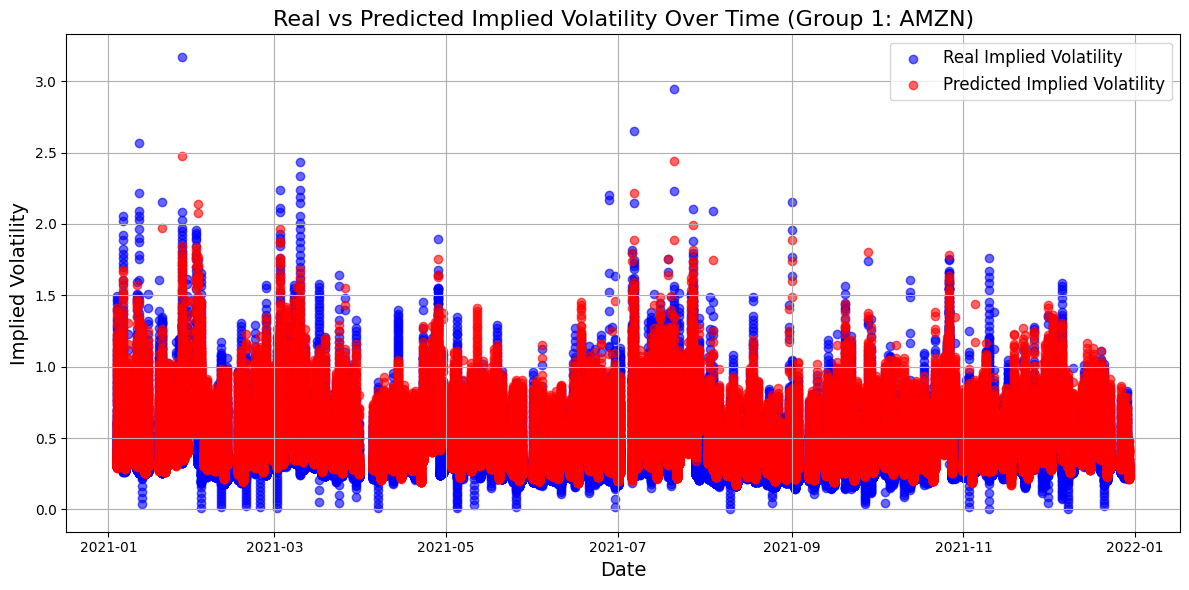

717/717 ━━━━━━━━━━━━━━━━━━━━ 0s 282us/step


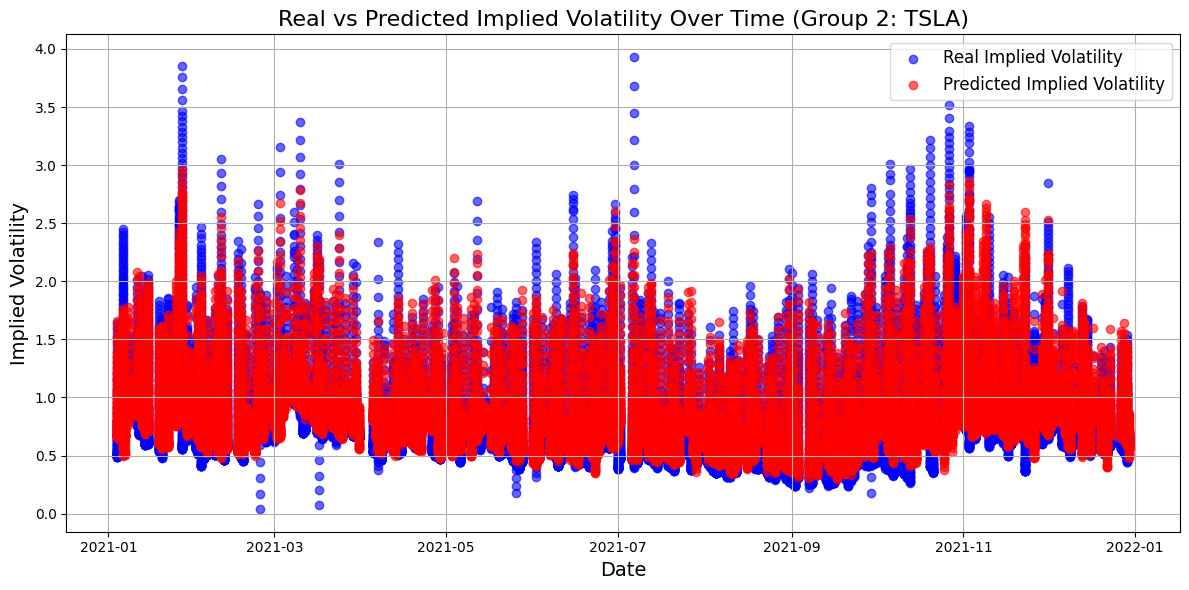

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 233us/step
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 229us/step
398/398 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 237us/step


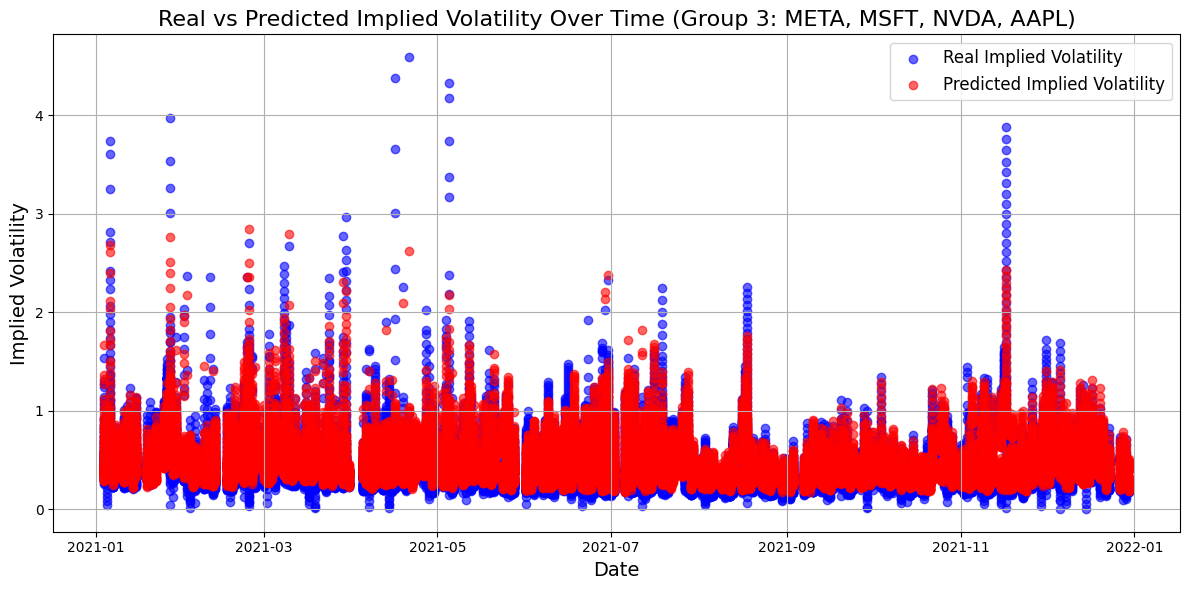

28054
28054
[0.01807181 0.01819453 0.02694107 ... 0.02328482 0.0148913  0.04899008]
Daily average errors calculated for 250 days.
Newey-West Standard Error (Based on Daily Averages): 0.0036328430834698783
Daily average errors and Newey-West statistics saved to /Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Notebooks/Notebook_modeling/db_performance_evaluation/nn_META_MSFT_NVDA_AAPL.csv
Overall Combined RMSE: 0.13827665708458864
Overall Combined R²: 0.7507379717000294
Group 1:
  Tickers: ['AMZN']
  Group RMSE: 0.10780330253201657
  Group R²: 0.8167641453530561

Group 2:
  Tickers: ['TSLA']
  Group RMSE: 0.18512780213109567
  Group R²: 0.8195402156853056

Group 3:
  Tickers: ['META', 'MSFT', 'NVDA', 'AAPL']
  Group RMSE: 0.13827665708458864
  Group R²: 0.7507379717000294

Group 1 ENet Importance (AMZN) in correct order: [0.11360677392089381, 0.470991933015997, 0.20115550288221737, 0.0, 0.11617607700761248, 0.0, 0.09806971317327938, 0.0, 0.0]
Group 2 ENet Importance (TSLA) in correc

/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_4058/2907560046.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_data['Errors'] = errors_test  # Add errors to the test dataset


In [13]:
def newey_west_standard_error(errors, lag=1):
    """
    Computes the Newey-West standard error for the series of prediction errors.
    
    Parameters:
    - errors: Array-like of prediction errors
    - lag: Maximum lag to use for the Newey-West estimator (default is 1)
    
    Returns:
    - Newey-West standard error of the prediction errors
    """
    X = np.ones(len(errors))  # Constant term for OLS
    ols_model = sm.OLS(errors, X).fit(cov_type='HAC', cov_kwds={'maxlags': lag})
    return ols_model.bse[0]  # Standard error of the constant term

def predict_test_data_by_groups_with_scatter_plots(IV, test_data, model, selected_features, ticker_groups, n_runs=1):
    """
    Predict and evaluate performance for defined groups of tickers, and plot real vs. predicted IV over time using scatter plots.

    Parameters:
    IV (str): The name of the independent variable to predict.
    test_data (pd.DataFrame): The test dataset.
    model: The trained neural network model.
    selected_features (list): The list of features used for modeling.
    ticker_groups (list): List of ticker groups for combined evaluation.
    n_runs (int): Number of times to repeat predictions for averaging.

    Returns:
    dict: Contains RMSE and \(R^2\) values for each group and overall metrics.
    """
    group_results = {}

    for group_idx, group in enumerate(ticker_groups):
        if isinstance(group, str):
            tickers = [group]
        else:
            tickers = group

        # Filter data for the current group
        group_data = test_data[test_data['Ticker'].isin(tickers)]

        combined_actual = []
        combined_predicted = []
        combined_dates = []

        for ticker in tickers:
            ticker_data = group_data[group_data['Ticker'] == ticker]
            y_actual = ticker_data[IV]
            X = ticker_data[selected_features]
            dates = ticker_data['date']

            # Aggregate real, predicted, and date values for group plotting
            for _ in range(n_runs):
                y_pred = model.predict(X)
                combined_actual.extend(y_actual)
                combined_predicted.extend(y_pred)
                combined_dates.extend(dates)

        # Combined metrics for the group
        combined_actual = np.array(combined_actual)
        combined_predicted = np.array(combined_predicted)
        combined_dates = pd.to_datetime(combined_dates)

        group_rmse = np.sqrt(mean_squared_error(combined_actual, combined_predicted))
        group_r2 = r2_score(combined_actual, combined_predicted)

        group_results[f'Group {group_idx + 1}'] = {
            'Group_Tickers': tickers,
            'Group_RMSE': group_rmse,
            'Group_R²': group_r2
        }

        # Plot real vs predicted IV for the group as scatter plot
        plot_real_vs_predicted_scatter(group_data, combined_dates, combined_actual, combined_predicted, f'Group {group_idx + 1}: {", ".join(tickers)}')


        # Calculate overall metrics based on combined data (not weighted)
    combined_actual = np.array(combined_actual)
    combined_predicted = np.array(combined_predicted)
    combined_predicted = combined_predicted.flatten()
    print(len(combined_actual))
    print(len(combined_predicted))


    # Example calculation
    errors_test = combined_actual - combined_predicted
    print(errors_test)
    group_data['Errors'] = errors_test  # Add errors to the test dataset

    # Group errors by date and calculate daily averages
    if 'date' in group_data.columns:
        daily_avg_errors = group_data.groupby('date')['Errors'].mean()
        print(f"Daily average errors calculated for {len(daily_avg_errors)} days.")
    else:
        raise ValueError("The dataset does not contain a 'date' column.")

    # Calculate Newey-West standard error using daily averages
    nw_std_error_test = newey_west_standard_error(daily_avg_errors.values, lag=1)
    print(f"Newey-West Standard Error (Based on Daily Averages): {nw_std_error_test}")

    # Save the daily errors and Newey-West standard error into a dynamically named CSV
    group_name = "_".join(tickers)  # Join tickers with an underscore
    file_path = f'/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Notebooks/Notebook_modeling/db_performance_evaluation/nn_{group_name}.csv'

    # Create a DataFrame with daily averaged errors and repeated Newey-West standard error
    dm_test_data = pd.DataFrame({
        'Date': daily_avg_errors.index,
        'Daily Avg Errors': daily_avg_errors.values,
        'Newey-West Std Error': [nw_std_error_test] * len(daily_avg_errors)
    })

    # Save the DataFrame to a CSV
    dm_test_data.to_csv(file_path, index=False)
    print(f"Daily average errors and Newey-West statistics saved to {file_path}")

    overall_combined_rmse = np.sqrt(mean_squared_error(combined_actual, combined_predicted))
    overall_combined_r2 = r2_score(combined_actual, combined_predicted)

    print(f'Overall Combined RMSE: {overall_combined_rmse}')
    print(f'Overall Combined R²: {overall_combined_r2}')

    # return combined_actual, combined_predicted, {
    #     'Overall_Combined_RMSE': overall_combined_rmse,
    #     'Overall_Combined_R²': overall_combined_r2
    # }

    return group_results


def plot_real_vs_predicted_scatter(test_data, dates, real_values, predicted_values, title):
    """
    Plot Real vs Predicted Implied Volatility over time using scatter plots.

    Parameters:
    test_data (pd.DataFrame): The test dataset containing the date information.
    dates (array-like): Dates for the test data.
    real_values (array-like): Real implied volatility values.
    predicted_values (array-like): Predicted implied volatility values.
    title (str): Title of the plot.
    """
    plt.figure(figsize=(12, 6))
    plt.scatter(dates, real_values, label='Real Implied Volatility', color='blue', alpha=0.6)
    plt.scatter(dates, predicted_values, label='Predicted Implied Volatility', color='red', alpha=0.6)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Implied Volatility', fontsize=14)
    plt.title(f'Real vs Predicted Implied Volatility Over Time ({title})', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Example usage
ticker_groups = ['AMZN', 'TSLA', ['META', 'MSFT', 'NVDA', 'AAPL']]
# ticker_groups = ['AMZN']
results = predict_test_data_by_groups_with_scatter_plots(
    IV=impl_volatility,
    test_data=datat,
    model=final_model_nn,
    selected_features=totalList,
    ticker_groups=ticker_groups,
    n_runs=1
)

# Print results for each group
for group_name, group_result in results.items():
    print(f"{group_name}:")
    print(f"  Tickers: {group_result['Group_Tickers']}")
    print(f"  Group RMSE: {group_result['Group_RMSE']}")
    print(f"  Group R²: {group_result['Group_R²']}")
    print()

# Define the correct feature order
correct_order = [
    'T',
    'moneyness',
    'previous_iv',
    'ticker_TSLA',
    'cp_flag',
    '2Y_bond',
    'ticker_AMZN',
    'RET',
    'spread_option'
]

# Initialize lists to store feature importance values for each group
group1_importance_enet = []
group2_importance_enet = []
group3_importance_enet = []

# Extract and reorder the feature importance values for each group
for group_name, results in group_importance_results.items():
    importance_df = results['Feature Importance']
    # Reorder the importance values to match the correct order
    importance_dict = dict(zip(importance_df['Feature'], importance_df['Importance']))
    reordered_importance = [importance_dict.get(feature, 0) for feature in correct_order]
    if group_name == "Group 1 (AMZN)":
        group1_importance_enet = reordered_importance
    elif group_name == "Group 2 (TSLA)":
        group2_importance_enet = reordered_importance
    elif group_name == "Group 3 (META, MSFT, NVDA, AAPL)":
        group3_importance_enet = reordered_importance

# Output the lists for verification
print("Group 1 ENet Importance (AMZN) in correct order:", group1_importance_enet)
print("Group 2 ENet Importance (TSLA) in correct order:", group2_importance_enet)
print("Group 3 ENet Importance (META, MSFT, NVDA, AAPL) in correct order:", group3_importance_enet)



Calculating feature importance for group: Group 1 (AMZN)
1545/1545 ━━━━━━━━━━━━━━━━━━━━ 0s 239us/step
Baseline R² (OOS): 0.8168
1545/1545 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
Feature: T, Baseline R²: 0.8168, Perturbed R²: 0.5941, Drop: 0.2226
1545/1545 ━━━━━━━━━━━━━━━━━━━━ 0s 213us/step
Feature: moneyness, Baseline R²: 0.8168, Perturbed R²: -0.1063, Drop: 0.9231
1545/1545 ━━━━━━━━━━━━━━━━━━━━ 0s 208us/step
Feature: previous_iv, Baseline R²: 0.8168, Perturbed R²: 0.4225, Drop: 0.3942
1545/1545 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step
Feature: spread_option, Baseline R²: 0.8168, Perturbed R²: 0.8307, Drop: 0.0000
1545/1545 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step
Feature: 2Y_bond, Baseline R²: 0.8168, Perturbed R²: 0.8258, Drop: 0.0000
1545/1545 ━━━━━━━━━━━━━━━━━━━━ 0s 202us/step
Feature: RET, Baseline R²: 0.8168, Perturbed R²: 0.8212, Drop: 0.0000
1545/1545 ━━━━━━━━━━━━━━━━━━━━ 0s 201us/step
Feature: cp_flag, Baseline R²: 0.8168, Perturbed R²: 0.5891, Drop: 0.2277
1545/1545 ━━━━━━━━━━━━━━━━━━━━ 0s 20

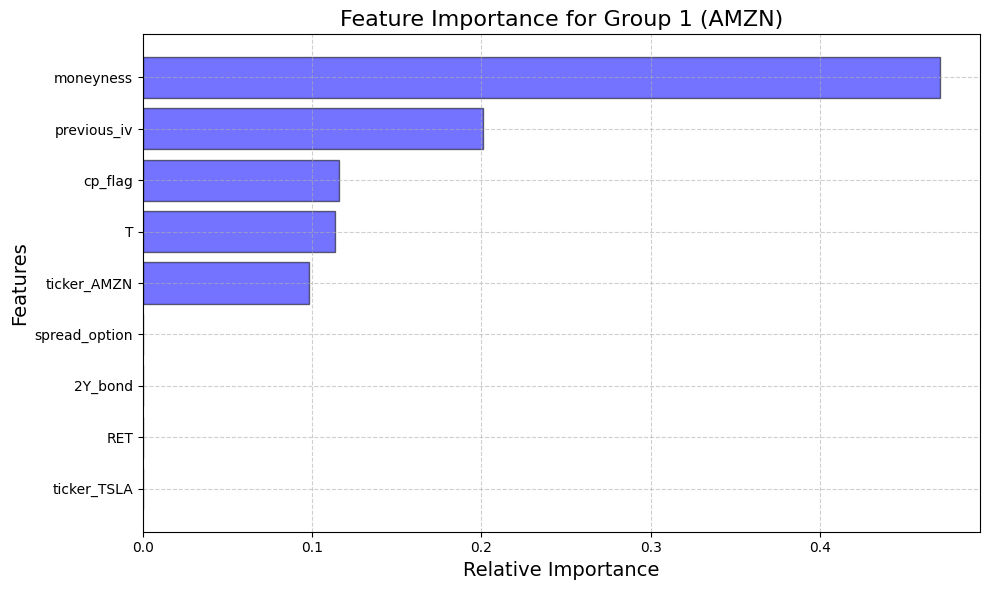

Baseline R² for Group 2 (TSLA): 0.8195


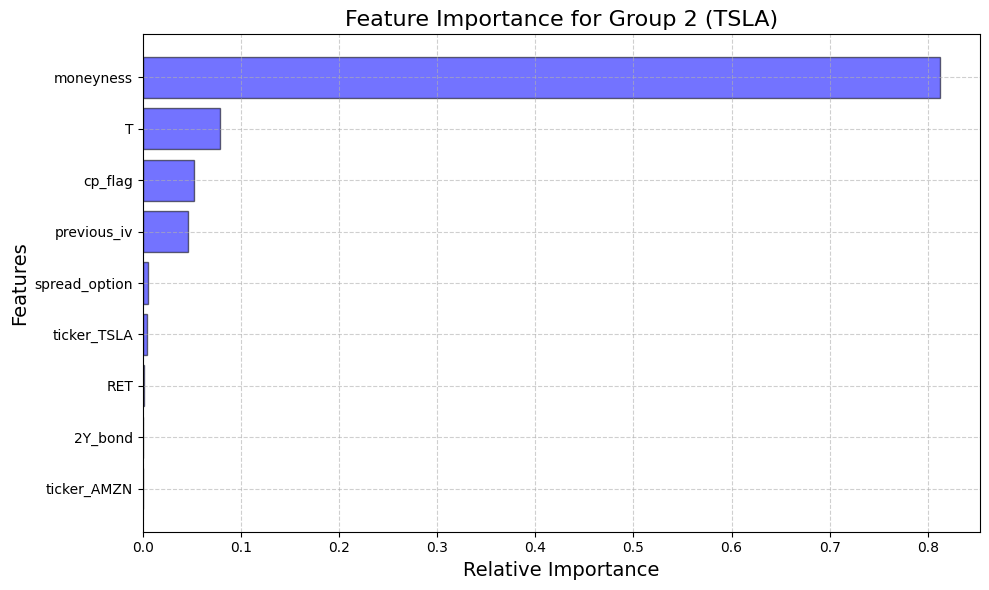

Baseline R² for Group 3 (META, MSFT, NVDA, AAPL): 0.7507


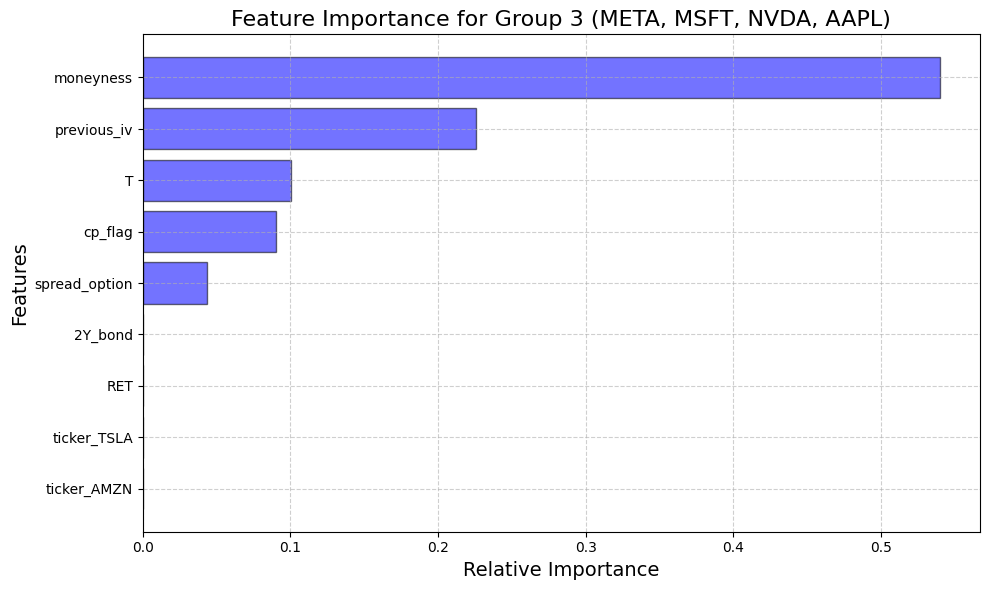

In [11]:
def calculate_feature_importance_r2_nn(data_test, features, target, model):
    """
    Calculate feature importance for NN based on the relative drop in R²_oos when a feature is set to zero.

    Parameters:
    - data_test: Test dataset
    - features: List of feature names
    - target: Target variable (e.g., implied volatility)
    - model: Trained neural network model
    
    Returns:
    - importance_df: DataFrame with feature importance values.
    - baseline_r2: Baseline R²_oos value.
    """
    # Prepare the test dataset
    X_test = data_test[features].values
    y_test = data_test[target].values

    # Predict on the test data and calculate baseline R²_oos
    y_test_pred = model.predict(X_test).flatten()
    baseline_r2 = r2_score(y_test, y_test_pred)
    print(f"Baseline R² (OOS): {baseline_r2:.4f}")

    # Calculate the drop in R²_oos for each feature
    r2_drops = []
    for i, feature in enumerate(features):
        # Perturb the test data by setting the feature column to zero
        X_test_zeroed = X_test.copy()
        X_test_zeroed[:, i] = 0

        # Predict and calculate R²_oos
        y_test_pred_zeroed = model.predict(X_test_zeroed).flatten()
        r2_zeroed = r2_score(y_test, y_test_pred_zeroed)
        r2_drop = max(0, baseline_r2 - r2_zeroed)  # Ensure the drop is non-negative
        r2_drops.append(r2_drop)

        print(f"Feature: {feature}, Baseline R²: {baseline_r2:.4f}, Perturbed R²: {r2_zeroed:.4f}, Drop: {r2_drop:.4f}")

    # Normalize the importance scores
    r2_importance = np.array(r2_drops)
    if r2_importance.sum() > 0:
        r2_importance = r2_importance / r2_importance.sum()  # Normalize to sum to 1
    else:
        r2_importance = np.zeros_like(r2_importance)  # Handle edge case where all drops are zero

    # Create a DataFrame for feature importance
    importance_df = pd.DataFrame({
        'Feature': features,
        'Importance': r2_importance
    }).sort_values(by='Importance', ascending=False)

    return importance_df, baseline_r2

def plot_feature_importance(importance_df, title="Feature Importance"):
    """
    Plot feature importance as a bar chart.
    
    Parameters:
    - importance_df: DataFrame containing feature names and importance scores.
    - title: Title of the plot.
    """
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='blue', edgecolor='black', alpha=0.55)
    plt.xlabel('Relative Importance', fontsize=14)
    plt.ylabel('Features', fontsize=14)
    plt.title(title, fontsize=16)
    plt.gca().invert_yaxis()  # Invert y-axis for descending order
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
    
def calculate_feature_importance_r2_nn_grouped(data_test, features, target, model, groups):
    """
    Calculate feature importance for NN for each group of tickers based on the relative drop in R²_oos.

    Parameters:
    - data_test: Test dataset.
    - features: List of feature names.
    - target: Target variable (e.g., implied volatility).
    - model: Trained neural network model.
    - groups: Dictionary where keys are group names and values are lists of tickers in each group.

    Returns:
    - group_importance_results: Dictionary of feature importance DataFrames for each group.
    """
    group_importance_results = {}

    for group_name, tickers in groups.items():
        print(f"Calculating feature importance for group: {group_name}")
        
        # Filter the test dataset for the current group
        group_data = data_test[data_test['Ticker'].isin(tickers)]
        
        # Calculate feature importance for the group
        importance_df, baseline_r2 = calculate_feature_importance_r2_nn(
            data_test=group_data,
            features=features,
            target=target,
            model=model
        )
        
        group_importance_results[group_name] = {
            'Feature Importance': importance_df,
            'Baseline R²': baseline_r2
        }

        print(f"Feature Importance for {group_name}:\n{importance_df}\n")

    return group_importance_results


# Define groups of tickers
ticker_groups = {
    "Group 1 (AMZN)": ["AMZN"],
    "Group 2 (TSLA)": ["TSLA"],
    "Group 3 (META, MSFT, NVDA, AAPL)": ["META", "MSFT", "NVDA", "AAPL"]
}

# Calculate feature importance for each group
group_importance_results = calculate_feature_importance_r2_nn_grouped(
    data_test=datat,
    features=totalList,
    target=impl_volatility,
    model=final_model_nn,  # Trained NN model
    groups=ticker_groups
)

# Plot feature importance for each group
for group_name, results in group_importance_results.items():
    print(f"Baseline R² for {group_name}: {results['Baseline R²']:.4f}")
    plot_feature_importance(results['Feature Importance'], title=f"Feature Importance for {group_name}")


3139/3139 ━━━━━━━━━━━━━━━━━━━━ 1s 246us/step
Baseline R² (OOS): 0.7119
3139/3139 ━━━━━━━━━━━━━━━━━━━━ 1s 210us/step
Feature: T, Baseline R²: 0.7119, Perturbed R²: 0.6945, Drop: 0.0174
3139/3139 ━━━━━━━━━━━━━━━━━━━━ 1s 207us/step
Feature: moneyness, Baseline R²: 0.7119, Perturbed R²: 0.2590, Drop: 0.4529
3139/3139 ━━━━━━━━━━━━━━━━━━━━ 1s 204us/step
Feature: previous_iv, Baseline R²: 0.7119, Perturbed R²: 0.4614, Drop: 0.2505
3139/3139 ━━━━━━━━━━━━━━━━━━━━ 1s 242us/step
Feature: spread_option, Baseline R²: 0.7119, Perturbed R²: 0.6901, Drop: 0.0218
3139/3139 ━━━━━━━━━━━━━━━━━━━━ 1s 241us/step
Feature: 2Y_bond, Baseline R²: 0.7119, Perturbed R²: 0.7046, Drop: 0.0073
3139/3139 ━━━━━━━━━━━━━━━━━━━━ 1s 203us/step
Feature: RET, Baseline R²: 0.7119, Perturbed R²: 0.7136, Drop: 0.0000
3139/3139 ━━━━━━━━━━━━━━━━━━━━ 1s 215us/step
Feature: cp_flag, Baseline R²: 0.7119, Perturbed R²: 0.6361, Drop: 0.0758
3139/3139 ━━━━━━━━━━━━━━━━━━━━ 1s 236us/step
Feature: ticker_TSLA, Baseline R²: 0.7119, Pertur

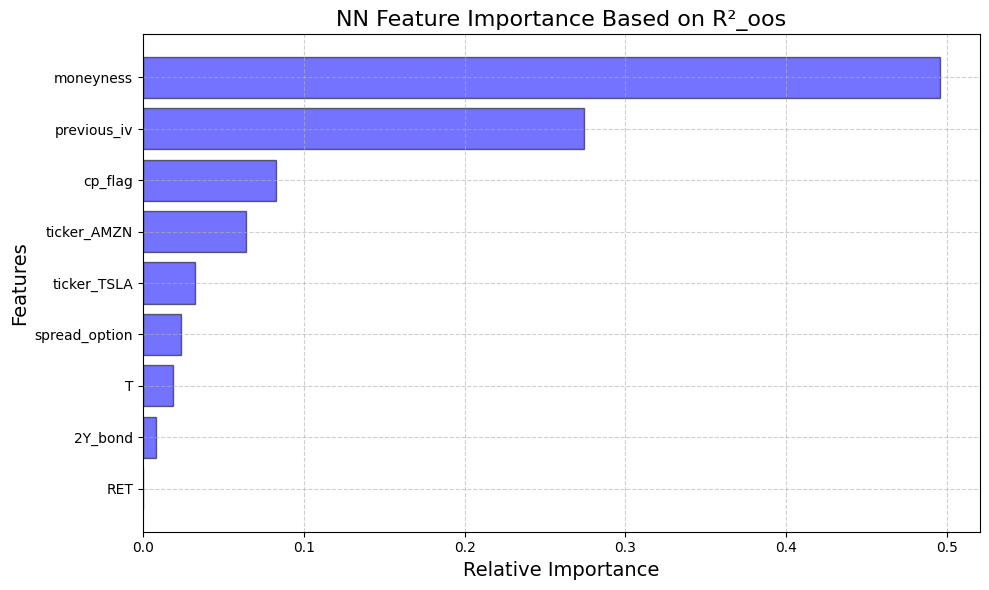

In [28]:
def calculate_feature_importance_r2_nn(data_test, features, target, model):
    """
    Calculate feature importance for NN based on the relative drop in R²_oos when a feature is set to zero.

    Parameters:
    - data_test: Test dataset
    - features: List of feature names
    - target: Target variable (e.g., implied volatility)
    - model: Trained neural network model
    
    Returns:
    - importance_df: DataFrame with feature importance values.
    - baseline_r2: Baseline R²_oos value.
    """
    # Prepare the test dataset
    X_test = data_test[features].values
    y_test = data_test[target].values

    # Predict on the test data and calculate baseline R²_oos
    y_test_pred = model.predict(X_test).flatten()
    baseline_r2 = r2_score(y_test, y_test_pred)
    print(f"Baseline R² (OOS): {baseline_r2:.4f}")

    # Calculate the drop in R²_oos for each feature
    r2_drops = []
    for i, feature in enumerate(features):
        # Perturb the test data by setting the feature column to zero
        X_test_zeroed = X_test.copy()
        X_test_zeroed[:, i] = 0

        # Predict and calculate R²_oos
        y_test_pred_zeroed = model.predict(X_test_zeroed).flatten()
        r2_zeroed = r2_score(y_test, y_test_pred_zeroed)
        r2_drop = max(0, baseline_r2 - r2_zeroed)  # Ensure the drop is non-negative
        r2_drops.append(r2_drop)

        print(f"Feature: {feature}, Baseline R²: {baseline_r2:.4f}, Perturbed R²: {r2_zeroed:.4f}, Drop: {r2_drop:.4f}")

    # Normalize the importance scores
    r2_importance = np.array(r2_drops)
    if r2_importance.sum() > 0:
        r2_importance = r2_importance / r2_importance.sum()  # Normalize to sum to 1
    else:
        r2_importance = np.zeros_like(r2_importance)  # Handle edge case where all drops are zero

    # Create a DataFrame for feature importance
    importance_df = pd.DataFrame({
        'Feature': features,
        'Importance': r2_importance
    }).sort_values(by='Importance', ascending=False)

    return importance_df, baseline_r2


def plot_feature_importance(importance_df, title="Feature Importance"):
    """
    Plot feature importance as a bar chart.
    
    Parameters:
    - importance_df: DataFrame containing feature names and importance scores.
    - title: Title of the plot.
    """
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='blue', edgecolor='black', alpha=0.55)
    plt.xlabel('Relative Importance', fontsize=14)
    plt.ylabel('Features', fontsize=14)
    plt.title(title, fontsize=16)
    plt.gca().invert_yaxis()  # Invert y-axis for descending order
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# Calculate feature importance for NN
feature_importance_nn, baseline_r2_nn = calculate_feature_importance_r2_nn(
    data_test=datat,
    features=totalList,
    target='impl_volatility',
    model=final_model_nn  # Trained NN model
)

# Print and visualize the feature importance
print("Feature Importance (R²_oos drop) for Neural Network:")
print(feature_importance_nn)

plot_feature_importance(feature_importance_nn, title="NN Feature Importance Based on R²_oos")


In [30]:
# feature_importance_nn["Importance"].tolist()
feature_importance_nn["Feature"].tolist()

['moneyness',
 'previous_iv',
 'cp_flag',
 'ticker_AMZN',
 'ticker_TSLA',
 'spread_option',
 'T',
 '2Y_bond',
 'RET']

In [14]:
# Flatten predicted_data if it's 2D
predicted_data_flattened = predicted_data.flatten()

# Ensure the shapes match
if predicted_data_flattened.shape == actual_data.shape:
    difference = actual_data - predicted_data_flattened
else:
    print("Shapes do not match. Check the dimensions of the arrays.")

# Output the difference
print(difference)

[ 0.07313926  0.04226846  0.08486538 ... -0.14026352 -0.13416991
 -0.13444146]


In [17]:
datat

,date,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,...,total_iv_weighted,previous_iv,previous_iv_all,ticker_AAPL,ticker_AMZN,ticker_META,ticker_MSFT,ticker_NVDA,ticker_TSLA,Ticker
0,2021-01-04,0,-1.259461,-0.464302,-0.473113,-0.119704,-0.033247,0.622737,-0.216815,0.190278,...,-0.169351,-0.501600,-0.211828,1,0,0,0,0,0,AAPL
1,2021-01-04,0,-1.254711,-0.450505,-0.459201,0.462214,0.205921,0.508636,-0.460255,0.983377,...,-0.140783,-0.501600,-0.211828,1,0,0,0,0,0,AAPL
2,2021-01-04,1,-1.249011,-0.366858,-0.377419,3.693194,0.792270,0.433412,1.441396,2.296520,...,0.433592,-0.501600,-0.211828,1,0,0,0,0,0,AAPL
3,2021-01-04,1,-1.248061,-0.388848,-0.398919,10.713529,5.918095,0.428775,1.255893,2.330219,...,1.145629,-0.501600,-0.211828,1,0,0,0,0,0,AAPL
4,2021-01-04,1,-1.247111,-0.407388,-0.417046,3.797118,0.744735,0.426358,1.072019,2.266863,...,0.212903,-0.501600,-0.211828,1,0,0,0,0,0,AAPL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106281,2021-12-30,1,-0.245812,-0.469476,-0.477328,-0.077215,0.019763,0.840809,0.013198,-0.467738,...,-0.169389,0.198613,-0.314645,0,0,0,0,0,1,TSLA
106282,2021-12-30,1,-0.250562,-0.468614,-0.476485,0.441831,0.662109,0.822016,0.016923,-0.464397,...,-0.157560,0.198613,-0.314645,0,0,0,0,0,1,TSLA
106283,2021-12-30,0,-0.359812,-0.148688,-0.148092,1.159970,-0.034989,0.460012,-1.137629,0.129974,...,0.558154,0.198613,-0.314645,0,0,0,0,0,1,TSLA
106284,2021-12-30,1,-0.364562,0.198402,0.208125,1.402556,-0.057886,0.451085,1.786211,0.102050,...,1.543815,0.198613,-0.314645,0,0,0,0,0,1,TSLA


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

def predict_test_data_per_ticker(IV, train_data, test_data, model, selected_features, n_runs=10):
    """
    Predict the target variable for the test set using the trained model and scale data with MinMaxScaler.
    
    Parameters:
    IV (str): The name of the independent variable to predict.
    train_data (pd.DataFrame): The training dataset used for fitting the scaler.
    test_data (pd.DataFrame): The test dataset.
    model: The trained ElasticNet model.
    selected_features (list): The list of features selected by ElasticNet during training.
    n_runs (int): Number of times to repeat predictions for averaging.

    Returns:
    list: Averaged RMSE and R² values for each ticker in the test set.
    """
    results_list_all = []  # Initialize list to store results
    unique_tickers = test_data['Ticker'].unique()
    
    for ticker in unique_tickers:
        # Filter the data for the current ticker
        data_ticker = test_data[test_data['Ticker'] == ticker]
        
        # Separate features and target for the ticker
        y_ticker_actual = data_ticker[IV]
        X_ticker = data_ticker[selected_features]
        
        rmse_scores = []
        r2_scores = []

        # Run predictions n_runs times
        for _ in range(n_runs):
            y_ticker_pred = model.predict(X_ticker)

            # Calculate RMSE and R² for the ticker-specific implied volatility prediction
            rmse_ticker = np.sqrt(mean_squared_error(y_ticker_actual, y_ticker_pred))
            r2_ticker = r2_score(y_ticker_actual, y_ticker_pred)

            rmse_scores.append(rmse_ticker)
            r2_scores.append(r2_ticker)

        # Calculate average RMSE and R² over n_runs
        avg_rmse = np.mean(rmse_scores)
        avg_r2 = np.mean(r2_scores)
        
        # Save averaged results in the list
        results_list_all.append({
            'Ticker': ticker,
            'RMSE': avg_rmse,
            'R²': avg_r2
        })
        print(f'{ticker} Average RMSE (over {n_runs} runs): {avg_rmse}')
        print(f'{ticker} Average R² (over {n_runs} runs): {avg_r2}')

        # Plot Real vs Predicted values (last run)
        plot_real_vs_predicted(data_ticker, y_ticker_actual, y_ticker_pred, f'Ticker: {ticker}')

    return results_list_all

def plot_real_vs_predicted(test_data, real_values, predicted_values, title):
    """
    Plot Real vs Predicted Implied Volatility over time.

    Parameters:
    test_data (pd.DataFrame): The test dataset containing the date information.
    real_values (np.array or pd.Series): The real implied volatility values.
    predicted_values (np.array or pd.Series): The predicted implied volatility values.
    title (str): The title for the plot.
    """
    plt.figure(figsize=(12, 6))
    
    # Scatter plot for Real Implied Volatility
    plt.scatter(test_data['date'], real_values, label='Real Implied Volatility', color='blue', alpha=0.6)
    
    # Scatter plot for Predicted Implied Volatility
    plt.scatter(test_data['date'], predicted_values, label='Predicted Implied Volatility', color='red', alpha=0.6)
    
    # Labels and title
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Implied Volatility', fontsize=14)
    plt.title(f'Real vs Predicted Implied Volatility Over Time ({title})', fontsize=16)
    
    # Add a legend
    plt.legend()
    
    # Grid for better visualization
    plt.grid(True)
    
    # Display the plot
    plt.show()

# Assuming `data_test_all`, `data_train_tot`, and `selected_features_final` are already defined
results_list_all = predict_test_data_per_ticker(
    'impl_volatility', data, datat_nor, final_model_nn, totalList, n_runs=10
)


NameError: name 'final_rf_model' is not defined

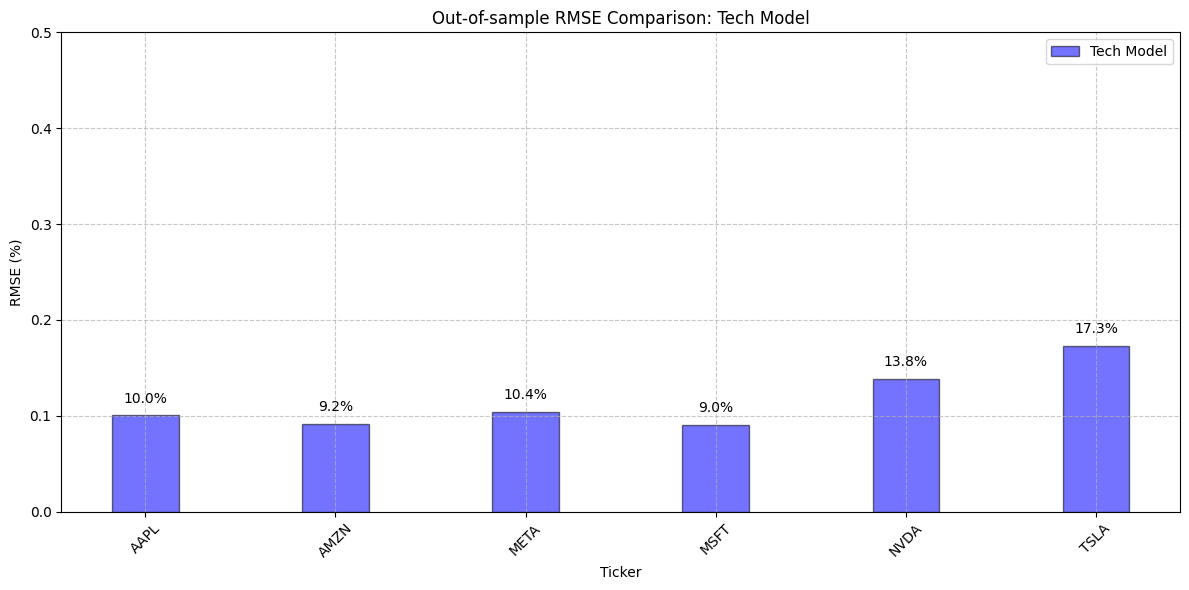

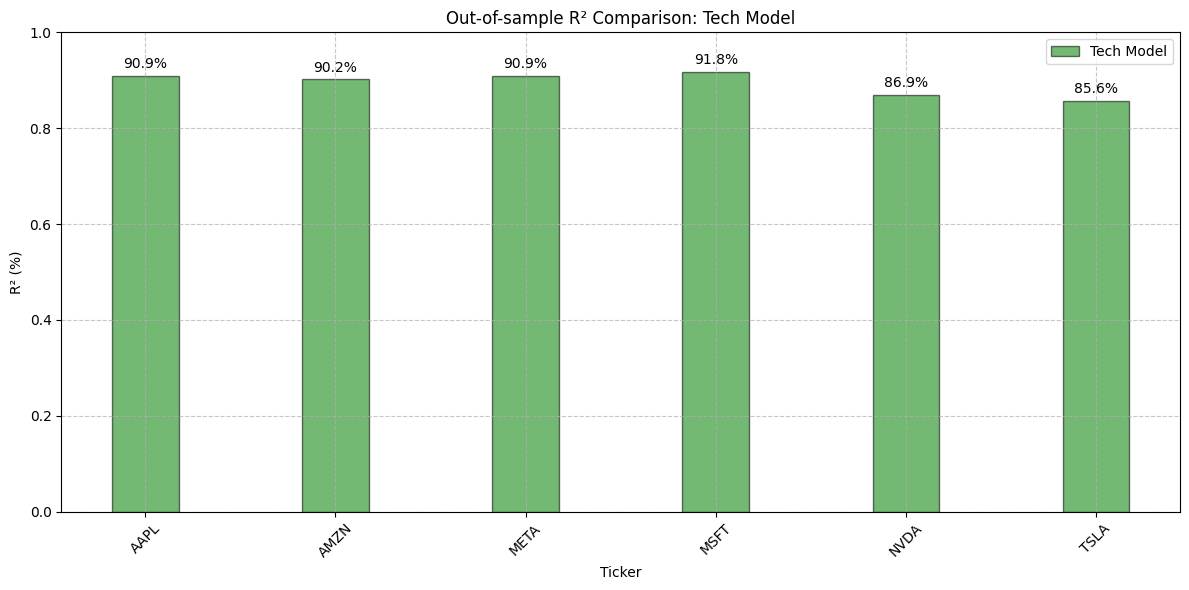

In [27]:
# Convert lists to DataFrames for easier plotting
results_list_all_df = pd.DataFrame(results_list_all).set_index('Ticker').sort_index()

# Define the x locations for the groups and bar width
x = np.arange(len(results_list_all_df.index))
width = 0.35  # Width of the bars

# Plot RMSE comparison
plt.figure(figsize=(12, 6))
bars_all_rmse = plt.bar(x, results_list_all_df['RMSE'], width=width, label='Tech Model', color='blue', alpha=0.55, edgecolor='black')

# Add percentage labels above bars for RMSE (converted to percentage format)
for bar in bars_all_rmse:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{bar.get_height() * 100:.1f}%', ha='center', va='bottom')

plt.xlabel('Ticker')
plt.ylabel('RMSE (%)')
plt.title('Out-of-sample RMSE Comparison: Tech Model')
plt.xticks(ticks=x, labels=results_list_all_df.index, rotation=45)
plt.legend()
plt.ylim([0, 0.5])  # Adjusted for percentage scale
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot R² comparison
plt.figure(figsize=(12, 6))
bars_all_r2 = plt.bar(x, results_list_all_df['R²'], width=width, label='Tech Model', color='green', alpha=0.55, edgecolor='black')

# Add percentage labels above bars for R² (converted to percentage format)
for bar in bars_all_r2:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{bar.get_height() * 100:.1f}%', ha='center', va='bottom')

plt.xlabel('Ticker')
plt.ylabel('R² (%)')
plt.title('Out-of-sample R² Comparison: Tech Model')
plt.xticks(ticks=x, labels=results_list_all_df.index, rotation=45)
plt.legend()
plt.ylim([0, 1])  # Adjusted for percentage scale
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [228]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from keras import regularizers
from keras.layers import Dense, Dropout, Input
from keras.models import Sequential
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from scikeras.wrappers import KerasRegressor
from keras.optimizers import RMSprop
import tensorflow as tf
import random

# Set random seeds for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

# Set the seed before training
set_seed(42)

# Function to calculate Newey-West standard error
def newey_west_standard_error(errors, lag=1):
    """
    Computes the Newey-West standard error for the series of prediction errors.
    
    Parameters:
    - errors: Array-like of prediction errors
    - lag: Maximum lag to use for the Newey-West estimator (default is 1)
    
    Returns:
    - Newey-West standard error of the prediction errors
    """
    X = np.ones(len(errors))  # Constant term for OLS
    ols_model = sm.OLS(errors, X).fit(cov_type='HAC', cov_kwds={'maxlags': lag})
    nw_std_error = ols_model.bse[0]  # Newey-West standard error
    return nw_std_error

# Define the model function with variable neurons, layers, and dropout rate
def create_model(input_dim, neurons=32, layers=1, dropout_rate=0.0):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))  # Input layer

    # First hidden layer
    model.add(Dense(neurons, activation='relu'))
    model.add(Dropout(dropout_rate))  # Dropout after the first hidden layer

    # Additional hidden layers
    for _ in range(layers - 1):
        model.add(Dense(neurons, activation='relu'))
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1, activation='linear'))  # Regression output layer

    # Compile the model
    model.compile(optimizer=RMSprop(learning_rate=0.001),
                  loss='mean_squared_error',
                  metrics=['mse'])
    return model

# Wrapping the model in KerasRegressor
def create_keras_regressor(input_dim):
    return KerasRegressor(model=create_model, input_dim=input_dim, verbose=1)

# Function to train the model and calculate Newey-West errors
def train_and_evaluate(train_x, train_y, combined_x, combined_y, test_x, test_y, model_name):
    # Get input dimension from the training data
    input_dim = combined_x.shape[1]
    
    # Create KerasRegressor
    model = create_keras_regressor(input_dim)

    # Initialize GridSearchCV with the model and parameter grid
    grid_search = GridSearchCV(estimator=model,
                               param_grid=param_grid,
                               scoring='neg_mean_squared_error',  # Scoring based on MSE
                               verbose=3,
                               cv=3, 
                               n_jobs=-1)

    # Perform hyperparameter tuning
    print(f"Running hyperparameter tuning for {model_name}...")
    grid_search.fit(combined_x, combined_y, verbose=1)

    # Get the best estimator and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    print(f"Best Parameters for {model_name}: {best_params}")

    # Predict on the test set
    predictions_test = best_model.predict(test_x)

    # Calculate test errors and Newey-West standard error
    errors_test = test_y - predictions_test
    nw_std_error = newey_west_standard_error(errors_test, lag=1)

    print(f"{model_name} Newey-West Standard Error: {nw_std_error:.4f}")

    return errors_test, nw_std_error

# Define the parameter grid for hyperparameter tuning
param_grid = {'batch_size': [32], 'epochs': [50], 'model__dropout_rate': [0.5], 'model__layers': [1], 'model__neurons': [16]}

# Call the function for Call options data
print("\nEvaluating Call options...")
calls_errors, calls_nw_std_error = train_and_evaluate(train_x_c, train_y_c, combined_x_c, combined_y_c, test_x_c, test_y_c, "Call Model")

# Call the function for Put options data
print("\nEvaluating Put options...")
puts_errors, puts_nw_std_error = train_and_evaluate(train_x_p, train_y_p, combined_x_p, combined_y_p, test_x_p, test_y_p, "Put Model")

# Pad the shorter error list with zeros to ensure both lists have the same length
max_length = max(len(puts_errors), len(calls_errors))

puts_errors_padded = np.pad(puts_errors, (0, max_length - len(puts_errors)), 'constant', constant_values=0)
calls_errors_padded = np.pad(calls_errors, (0, max_length - len(calls_errors)), 'constant', constant_values=0)

# Save the results to a DataFrame and CSV
dm_test_data = pd.DataFrame({
    'Put Errors': puts_errors_padded,
    'Call Errors': calls_errors_padded,
    'Put Newey-West Std Error': [puts_nw_std_error] * max_length,  # Constant value for all rows
    'Call Newey-West Std Error': [calls_nw_std_error] * max_length  # Constant value for all rows
})

# Specify the file path for the CSV
file_path = '/Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Notebooks/performence_evaluation/dm_test_errors_nn.csv'

# Save the DataFrame to the specified path
dm_test_data.to_csv(file_path, index=False)

print(f"Test errors and Newey-West statistics saved to {file_path}")



Evaluating Call options...
Running hyperparameter tuning for Call Model...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Epoch 1/50
Epoch 1/50
Epoch 1/50
1508/1508 ━━━━━━━━━━━━━━━━━━━━ 1s 374us/step - loss: 0.6407 - mse: 0.6407 
Epoch 2/50
1508/1508 ━━━━━━━━━━━━━━━━━━━━ 1s 375us/step - loss: 1.6090 - mse: 1.6090
Epoch 2/50
1508/1508 ━━━━━━━━━━━━━━━━━━━━ 1s 378us/step - loss: 0.9213 - mse: 0.9213
Epoch 2/50
1508/1508 ━━━━━━━━━━━━━━━━━━━━ 1s 370us/step - loss: 0.0611 - mse: 0.0611
Epoch 3/50
1508/1508 ━━━━━━━━━━━━━━━━━━━━ 1s 366us/step - loss: 0.1225 - mse: 0.1225
Epoch 3/50
1508/1508 ━━━━━━━━━━━━━━━━━━━━ 1s 374us/step - loss: 0.0720 - mse: 0.0720
Epoch 3/50
1508/1508 ━━━━━━━━━━━━━━━━━━━━ 1s 761us/step - loss: 0.0556 - mse: 0.0556
Epoch 4/50
1508/1508 ━━━━━━━━━━━━━━━━━━━━ 1s 765us/step - loss: 0.0613 - mse: 0.0613
Epoch 4/50
1508/1508 ━━━━━━━━━━━━━━━━━━━━ 1s 779us/step - loss: 0.0597 - mse: 0.0597
Epoch 4/50
1508/1508 ━━━━━━━━━━━━━━━━━━━━ 1s 385us/step - loss: 0.0509 - mse:

/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_18772/1964460253.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  nw_std_error = ols_model.bse[0]  # Newey-West standard error


Call Model Newey-West Standard Error: 0.0010

Evaluating Put options...
Running hyperparameter tuning for Put Model...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Epoch 1/50
1521/1521 ━━━━━━━━━━━━━━━━━━━━ 1s 334us/step - loss: 0.6656 - mse: 0.6656
Epoch 2/50
1521/1521 ━━━━━━━━━━━━━━━━━━━━ 1s 321us/step - loss: 0.0620 - mse: 0.0620
Epoch 3/50
1521/1521 ━━━━━━━━━━━━━━━━━━━━ 1s 577us/step - loss: 0.0570 - mse: 0.0570
Epoch 4/50
1521/1521 ━━━━━━━━━━━━━━━━━━━━ 1s 414us/step - loss: 0.0554 - mse: 0.0554
Epoch 5/50
1521/1521 ━━━━━━━━━━━━━━━━━━━━ 1s 329us/step - loss: 0.0573 - mse: 0.0573
Epoch 6/50
 336/1521 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step - loss: 0.0541 - mse: 0.0541Epoch 1/50
Epoch 1/50
1521/1521 ━━━━━━━━━━━━━━━━━━━━ 1s 428us/step - loss: 0.0535 - mse: 0.0535  
Epoch 7/50
1521/1521 ━━━━━━━━━━━━━━━━━━━━ 1s 497us/step - loss: 0.8271 - mse: 0.8271
Epoch 2/50
1521/1521 ━━━━━━━━━━━━━━━━━━━━ 1s 499us/step - loss: 1.4350 - mse: 1.4350
Epoch 2/50
1521/1521 ━━━━━━━━━━━━━━━━━━━━ 1s 

/var/folders/b4/wn87d6495j1_vytb8m33q3mm0000gn/T/ipykernel_18772/1964460253.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  nw_std_error = ols_model.bse[0]  # Newey-West standard error


Test errors and Newey-West statistics saved to /Users/sbjpipers/Desktop/FinalThesisQF/FinalThesisQF/Notebooks/performence_evaluation/dm_test_errors_nn.csv


In [219]:


import pandas as pd

# Get predictions
pred_y = best_model_call.predict(combined_x_c)

# Calculate mean squared error
mse_score = mean_squared_error(combined_y_c, pred_y)

# Assuming 'importance' is a list or array of feature importances
# Create a DataFrame with feature importance scores
feature_importance_networks = pd.DataFrame({
    'feature': combined_x_c.columns,  # Assuming feature names come from 'combined_x_p'
    'importance': importance  # Assuming 'importance' is a list or array of the same length as the number of features
})

# Print the MSE score (separately from the feature importances)
print(f"Mean Squared Error (MSE): {mse_score}")

# Sort by 'importance' in descending order
sorted_importance_c = feature_importance_networks.sort_values(by='importance', ascending=False)

# Display sorted feature importances
(sorted_importance_c)



2261/2261 ━━━━━━━━━━━━━━━━━━━━ 1s 240us/step
Mean Squared Error (MSE): 0.028032797160525903


,feature,importance
3,prev_day_iv,0.756283
17,2Y_bond,0.191636
18,CLOSE_vix,0.170249
16,1Y_bond,0.164074
0,T,0.091177
2,prev2_day_iv,0.064454
21,LOW_vix,0.053092
10,cumulative_return,0.037955
15,10Y_RIR,0.035771
7,ASK,0.032649


<Figure size 1000x600 with 0 Axes>

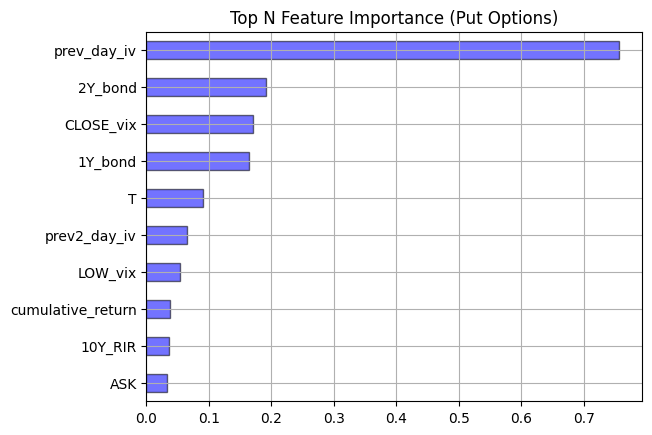

In [ ]:


import pandas as pd

# Get predictions
pred_y = best_model_call.predict(combined_x_c)

# Calculate mean squared error
mse_score = mean_squared_error(combined_y_c, pred_y)

# Assuming 'importance' is a list or array of feature importances
# Create a DataFrame with feature importance scores
feature_importance_networks = pd.DataFrame({
    'feature': combined_x_c.columns,  # Assuming feature names come from 'combined_x_p'
    'importance': importance  # Assuming 'importance' is a list or array of the same length as the number of features
})

# Print the MSE score (separately from the feature importances)
print(f"Mean Squared Error (MSE): {mse_score}")

# Sort by 'importance' in descending order
sorted_importance_c = feature_importance_networks.sort_values(by='importance', ascending=False)

# Display sorted feature importances
(sorted_importance_c)



import matplotlib.pyplot as plt

def plot_feature_importance_barplot(sorted_importance, top_n=5):
    """
    Create a horizontal bar plot showing the top N feature importance.

    Parameters:
    sorted_importance (pd.DataFrame): Sorted feature importance DataFrame.
    top_n (int): Number of top features to plot.
    """
    # Select the top N features based on importance
    top_features = sorted_importance.head(top_n)

    # Sort the top N features by importance for plotting
    top_features = top_features.sort_values(by='importance', ascending=True)

    # Plot the top N feature importance
    plt.figure(figsize=(10, 6))
    ax = top_features.plot(kind='barh', x='feature', y='importance', color='blue', alpha=0.55, edgecolor='black', linewidth=1)
    
    # Remove the y-label
    ax.set_ylabel('')
    
    # Remove the legend
    ax.get_legend().remove()
    
    # Add grid and title
    plt.grid(True)
    ax.set_title('Top N Feature Importance (Put Options)')
    
    # plt.tight_layout()  # Optional: for better layout
    plt.show()

# Example usage: Plot the top 5 features from Put options data
plot_feature_importance_barplot(sorted_importance_c, top_n=10)
